In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import sys  
print(sys.executable)

isola-2080ti-3.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

import gymnasium as gym


import argparse
import os
import random
import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

from functools import partial
import pickle


In [3]:
def make_env(env_id, idx, capture_video, run_name, gamma):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        env = gym.wrappers.NormalizeObservation(env)
        env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
        env = gym.wrappers.NormalizeReward(env, gamma=gamma)
        env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
        return env

    return thunk


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)

In [23]:
device = 'cuda:0'
# env setup
envs = gym.vector.AsyncVectorEnv(
    [make_env("HalfCheetah-v4", i, False, None, 0.99) for i in range(16)]
)

In [24]:
agent = Agent(envs).to(device).to(torch.float)
agent.load_state_dict(torch.load("../ppo_continuous_action.cleanrl_model"))
agent = agent.eval()

In [25]:
obs, info = envs.reset()
rets = []
for i in tqdm(range(6001)):
    obs = torch.tensor(obs).to(device).to(torch.float)
    with torch.no_grad():
        act, logprob, _, value = agent.get_action_and_value(obs)
    # act = torch.randn_like(act)
    obs, rew, term, trunc, infos = envs.step(act.cpu().numpy())
    
    if "final_info" not in infos:
        continue
    for info in infos["final_info"]:
        # Skip the envs that are not done
        if info is None:
            continue
        # print(f"global_step={i}, episodic_return={info['episode']['r']}")
        rets.append(info['episode']['r'])

  0%|          | 0/6001 [00:00<?, ?it/s]

In [19]:
rets_agent = np.concatenate(rets)

In [20]:
len(rets_agent)

1536

In [21]:
rets_agent.mean()

1030.9104

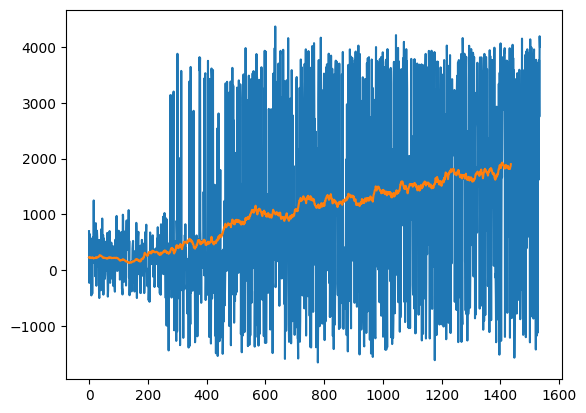

In [22]:
plt.plot(rets_agent)
plt.plot(np.convolve(rets_agent, np.ones(100)/100, mode='valid'))


In [58]:
rets_agent.mean()

1238.6538

In [59]:
rets_rand.mean()

-364.20978

In [6]:
from huggingface_hub import hf_hub_download
import joblib

REPO_ID = "cleanrl/MinerHard-v0-cleanba_ppo_envpool_procgen-seed1"
FILENAME = "cleanba_ppo_envpool_procgen.cleanrl_model"
model = joblib.load(
    hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
)

ValueError: unregistered extension code 161

In [46]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

In [2]:
import argparse
import os
import random
import time
import uuid
from collections import deque
from distutils.util import strtobool
from functools import partial
from typing import Sequence

import queue
import threading

import envpool
import flax
import flax.linen as nn
import gym
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState

/tmp/ipykernel_2205275/3754036050.py:7: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.util import strtobool


In [4]:
!pwd

/data/vision/phillipi/akumar01/synthetic-mdps/src


In [5]:
def make_env(env_id, seed, num_envs, async_batch_size=1):
    def thunk():
        envs = envpool.make(
            env_id,
            env_type="gym",
            num_envs=num_envs,
            batch_size=async_batch_size,
            seed=seed,
        )
        envs.num_envs = num_envs
        envs.single_action_space = envs.action_space
        envs.single_observation_space = envs.observation_space
        envs.is_vector_env = True
        return envs

    return thunk


class ResidualBlock(nn.Module):
    channels: int

    @nn.compact
    def __call__(self, x):
        inputs = x
        x = nn.relu(x)
        x = nn.Conv(
            self.channels,
            kernel_size=(3, 3),
        )(x)
        x = nn.relu(x)
        x = nn.Conv(
            self.channels,
            kernel_size=(3, 3),
        )(x)
        return x + inputs


class ConvSequence(nn.Module):
    channels: int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(
            self.channels,
            kernel_size=(3, 3),
        )(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2), padding="SAME")
        x = ResidualBlock(self.channels)(x)
        x = ResidualBlock(self.channels)(x)
        return x


class Network(nn.Module):
    channelss: Sequence[int] = (16, 32, 32)

    @nn.compact
    def __call__(self, x):
        # x = jnp.transpose(x, (0, 2, 3, 1))
        x = x / (255.0)
        for channels in self.channelss:
            x = ConvSequence(channels)(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        x = nn.relu(x)
        return x


class Critic(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Dense(1, kernel_init=orthogonal(1), bias_init=constant(0.0))(x)


class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x):
        return nn.Dense(self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0))(x)

In [6]:
model_path = "../data/cleanba_ppo_envpool_procgen.cleanrl_model"

In [7]:
# with open(model_path, "rb") as f:
#     a = flax.serialization.from_bytes(list, f.read())
with open(model_path, "rb") as f:
    a = flax.serialization.from_bytes( None, f.read())['1']
    network_params, actor_params, critic_params = a['0'], a['1'], a['2']

In [41]:
import gym
import procgen
env = gym.make("procgen-miner", distribution_mode="hard", num_levels=0, start_level=0)

from procgen import ProcgenEnv
env = ProcgenEnv(256, env_name="miner", distribution_mode="hard", num_levels=0, start_level=0)

In [42]:
network, actor, critic = Network(), Actor(15), Critic()

In [43]:
rng = jax.random.PRNGKey(0)
obs = env.reset()['rgb']
done = np.zeros(256, dtype=bool)
data = dict(obs=[], logits=[], act=[], rew=[], done=[])
ret = []
for t in tqdm(range(128*16)):
    hidden = network.apply(network_params, obs)
    logits = actor.apply(actor_params, hidden)
    # logits = jnp.zeros_like(logits)
    rng, _rng = jax.random.split(rng)
    action = jax.random.categorical(_rng, logits, axis=-1)
    next_obs, rew, next_done, info = env.step(np.array(action))
    data['obs'].append(obs)
    data['logits'].append(logits)
    data['act'].append(action)
    data['rew'].append(rew)
    data['done'].append(done)
    obs = next_obs['rgb']
    done = next_done
    ret.append(rew)

  0%|          | 0/2048 [00:00<?, ?it/s]

In [50]:
rearrange(np.array(data['obs']), "(t1 t2) n h w c -> (t1 n) t2 h w c", t2=128).shape

AttributeError: module 'torch' has no attribute 'Tensor'

In [37]:
ret = np.array(ret)

In [33]:
ret.sum(axis=0).mean()

3.5351562

In [39]:
ret.sum(axis=0).mean()

16.632812